# 1 Simple PV, Grid, and House Model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import importlib
from collections import OrderedDict
from datetime import datetime,tzinfo,timezone,timedelta
from pathlib import Path

In [3]:
import pandas as pd

import electrichouse as eh
from electrichouse.controllers import  PlanController,do_nothing_step_function
from electrichouse.components.inputs import (
    TempAndPVInputParams,
    TempAndPVComponent,
    HouseInflexibleLoadInputParams,
    HouseInflexibleLoadComponent,
)
from electrichouse.components.grid import (
    SingleRateTariffInputParams,
    SingleRateTariffComponent,
    OctopusAgileTariffComponent,
    GridInputParams,
    GridComponent,
)
importlib.reload(eh)

<module 'electrichouse' from '/Users/benaylott/projects/electrichouse/electrichouse/__init__.py'>

## Setup controller using plan 

The following is a simple example of how the 'plan' controller works. Components are initialised using the input_params passed here. Then in each iteration the controller first calls the state() methods on each component before dispatching them in the order given here. Prior to each component being dispatched the 'step function' is called which transforms outputs from previous components as well as input_params and control_params and returns the set of control_params passed to the dispatch method of the component. For many components here the step function does nothing. A 'do nothing' step function is provided for convenience.   

In [4]:
def grid_control(tandpv_pv_generation_kW,house_load_usage_kW,**kwargs): 
    return {"grid_requested_kw": -(tandpv_pv_generation_kW + house_load_usage_kW)}

plan=OrderedDict({
    "tandpv":{
        "input_params":TempAndPVInputParams(
            weather_data_filepath=Path(f"{os.path.abspath('')}/../data/weather_data.csv"),
            weather_data_year= 2014,
            pv_power_kW= 3,
        ),
        "control_params_init":{},
        "class":TempAndPVComponent,
        "step_function":do_nothing_step_function,
    },   
    "house_load":{
        "input_params":HouseInflexibleLoadInputParams(
            data_csv_filepath=Path(f"{os.path.abspath('')}/../data/loadm.csv"),
        ),
        "control_params_init":{},
        "class":HouseInflexibleLoadComponent,
        "step_function":do_nothing_step_function,
    },
    "grid":{
        "input_params":GridInputParams(
            min_kw=-3.68,
            max_kw= 23,
        ),
        "control_params_init":{},
        "class":GridComponent,
        "step_function":grid_control,
    },
    "tariff":{
        "input_params":SingleRateTariffInputParams(
            grid_import_price_pounds_per_kWh= 0.3,
            grid_export_price_pounds_per_kWh= 0.05,
        ),
        "control_params_init":{},
        "class":SingleRateTariffComponent,
        "step_function":do_nothing_step_function,
    },
})

In [5]:
sc=PlanController(
    time_interval=timedelta(minutes=30),
    start_time=datetime(year=2021, month=1, day=1, tzinfo=timezone.utc),
    end_time=datetime(year=2022, month=1, day=1, tzinfo=timezone.utc),
    input_params={},
    control_params_init={},
    plan=plan
)

The model is run time step by step by consuming the iterator from the BaseController. Each iteration corresponds to a new time step. Note the run time for a given model run (~1s).

In [6]:
%%time

output=[]
for res in sc:
    output.append(res)

CPU times: user 739 ms, sys: 6.22 ms, total: 745 ms
Wall time: 744 ms


In [7]:
outputd=pd.DataFrame.from_records(output,index='timestamp')

We can always check that energy balance is correct globally:

In [8]:
outputd[["tandpv_pv_generation_kW","house_load_usage_kW","grid_supplied_kW"]].values.sum(axis=1).sum(axis=0)

0.0

It is useful to convert the index to a pandas.DateTimeIndex which facilitates time-based analysis of the data using pandas. 

In [9]:
outputd.index=pd.DatetimeIndex(outputd.index)

### Total PV generation in kWh

Simple measures/statistics can be obtained using standard methods. The following is the total PV generation for the time period in kWh. 

In [10]:

outputd["tandpv_pv_generation_kW"].sum()/2

2919.65613

This is consistent with a yield of about 960 kWh / kW_p which is consistent with expectations for this location.

Or a plot of PV generation for 2 days in June...

/var/folders/mp/9bhmbnwn27xbd_gqz129g9880000gn/T/ipykernel_71687/2850489018.py:1: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  (outputd["tandpv_pv_generation_kW"]/2)[datetime(2021,6,3):datetime(2021,6,5)].plot()


<AxesSubplot: xlabel='timestamp'>

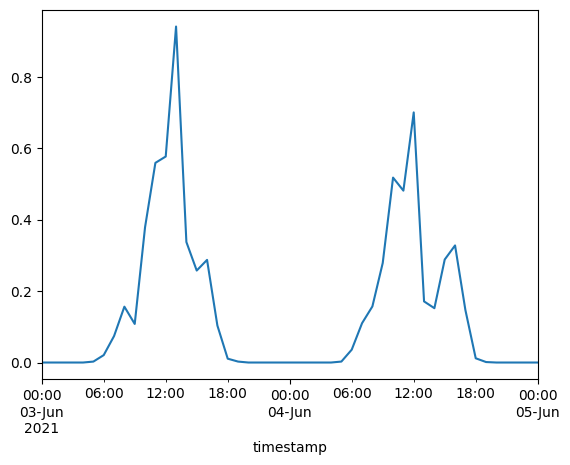

In [11]:
(outputd["tandpv_pv_generation_kW"]/2)[datetime(2021,6,3):datetime(2021,6,5)].plot()

The total house load in kWh for the period.

In [12]:
outputd["house_load_usage_kW"].sum()/2

-2939.459

Calculate daily PV generation in kWh

In [13]:
pv_daily_kWh=(outputd["tandpv_pv_generation_kW"]/2).resample(timedelta(days=1)).sum()

In [14]:
pv_daily_kWh.head()

timestamp
2021-01-01 00:00:00+00:00    0.37863
2021-01-02 00:00:00+00:00    6.55752
2021-01-03 00:00:00+00:00    3.05574
2021-01-04 00:00:00+00:00    0.67134
2021-01-05 00:00:00+00:00    1.46781
Freq: D, Name: tandpv_pv_generation_kW, dtype: float64

A histogram of daily PV output in kWh over year.

In [15]:
hist=pv_daily_kWh.hist()

### Total grid import cost in £

In [16]:
(outputd[outputd["grid_supplied_kW"]>0]["grid_supplied_kW"]/2).dot(outputd[outputd["grid_supplied_kW"]>0]["tariff_grid_import_price_pounds_per_kWh"])

608.0891609999996

### Total export income in £

In [17]:
-(outputd[outputd["grid_supplied_kW"]<0]["grid_supplied_kW"]/2).dot(outputd[outputd["grid_supplied_kW"]<0]["tariff_grid_export_price_pounds_per_kWh"])

100.35805000000005

### PV self consumption ratio % (what proportion PV generated is used on site)

In [18]:
(1+(outputd[outputd["grid_supplied_kW"]<0]["grid_supplied_kW"]/2).sum()/(outputd["tandpv_pv_generation_kW"].sum()/2))*100

31.253513748552297